# Reinforcement Learning
## Tensorflow Implementation
Author: Bingchen Wang

Last Updated: 8 Sep, 2022

---
<nav>
    <a href="../Machine%20Learning.ipynb">Machine Learning</a> |
    <a href="./Reinforcement Learning.ipynb">Reinforcement Learning</a>
</nav>

---

## Overview
- Concept Recap
- Import packages
    - Packages for training
    - Packages for the environment
- Specify the hyperparameters
- Get the data information
- Deep Q-Learning
    - Building the neural networks
    - Experience replay

### Concept Recap
**The Bellman's equations**:
$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$
**Idea**: Use a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. <br>
**Avoid instabilities**:
- Target network
    - Having a constantly moving target can lead to oscillations and instabilities. 
    - To avoid this, we can create a separate neural network (**target $\hat Q$-Network**) for generating the $y$ targets.
- Experience Replay 
    - When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them.
    - To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. <br>

**Loss**: Mean Squared Error
$$
\min \frac{1}{2m} \sum_{j=1}^m||y_j - \hat y_j||^2
$$
where
$$
y_j = R + \gamma \max_{a'}\hat Q_i(s',a'; w^-) \\
\hat y_j = Q_i(s,a; w)
$$

**Soft update**: Every $C$ time steps we will use the $\hat Q$-Network to generate the $y$ targets and update the weights of the target $\hat Q$-Network using the weights of the $Q$-Network. We will update the weights $w^-$ of the the target $\hat Q$-Network using a **soft update**. This means that we will update the weights $w^-$ using the following rule:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau\ll 1$.  

**Experience Replay**: Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment. For convenience, we will store the experiences as named tuples.

### Import packages

#### Packages for training

In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from collections import deque, namedtuple

# Set the random seed for TensorFlow
tf.random.set_seed(100)

#### Packages for the environment

[Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/#action-space)

In [2]:
import gym
import PIL.Image
import imageio
import IPython

### Specify the hyperparameters

In [3]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MINIBATCH_SIZE = 64       # size for the mini batches
TAU = 1e-3                # soft update parameter

### Get the data information

In [4]:
env = gym.make('LunarLander-v2')
env.reset()

#state_size = 8
#num_actions = 4

state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


<a name= "DQL"></a>
### Deep Q-Learning
#### Building the neural networks

In [5]:
q_network = Sequential([
    Input(shape = state_size),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = num_actions, activation = 'linear')
])

target_q_network = Sequential([
    Input(shape = state_size),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = num_actions, activation = 'linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

#q_network.summary()

2022-09-08 17:37:43.463828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Experience replay

In [6]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names = ["state","action","reward","next_state","done_val"])

# Create a memory buffer of size MEMORY_SIZE
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Create the experience replay get_experiences function
import random
def get_experiences(memory_buffer, minibatch_size = 64):
    experiences = random.sample(memory_buffer, k = minibatch_size)
    
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]), dtype = tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype = tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype = tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]), dtype = tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done_val for e in experiences if e is not None]).astype(np.uint8), dtype = tf.float32)
                                     
    return (states, actions, rewards, next_states, done_vals)

#### Compute the loss function

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

In [7]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Compute the loss of Deep Q-Learning
    
    :param experiences: a mini-batch of experiences generated using Experience Replay
    :param gamma: discount factor
    :param q_network: specified q_network to compute y predictions
    :param target_q_network: specified target_q_network to compute y targets
    :return: loss (MSE)
    """
    
    states, actions, rewards, next_states, done_vals = experiences
    
    #---Compute y targets---
    max_qsa = tf.reduce_max(target_q_network(next_states), axis = 1)
    y_targets = rewards + (1-done_vals)*gamma*max_qsa
    
    #---Compute y predictions---
    q_values = q_network(states)
    
    # tf.gather_nd(params, indices, batch_dims=0, name=None)
    #indices is a Tensor of indices into params. The index vectors are arranged along the last axis of indices.
    #This is similar to tf.gather, in which indices defines slices into the first dimension of params. In tf.gather_nd, indices defines slices into the first N dimensions of params, where N = indices.shape[-1].
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), #indicate which row to gather,
                                              tf.cast(actions, tf.int32)], #indicate the position in the row to gather
                                               axis = 1)) #stack by column
    
    #---Compute loss---
    loss = tf.keras.losses.MSE(y_targets, q_values)
    return loss

#### Update model weights using Auto Diff

In [8]:
# Create a function that updates the weights of the q models
def agent_learn(experiences, gamma, q_network, target_q_network):
    # Use the GradientTape function of tf to apply auto diff later
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    #Update the weights of the q_network
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    
    #Update the weights of the target_q_network (soft update)
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

# Create a function that checks if the conditions for updates is met:
def check_update_conditions(t, num_steps_update, memory_buffer, minibatch_size = 64):
    if (t+1) % num_steps_update == 0 and len(memory_buffer) > minibatch_size:
        return True
    else:
        return False
    

#### $\epsilon$-greedy policy
With probability $\epsilon$, randomly select an action (exploration). With probability $1-\epsilon$, select the best action that gives the highest Q value.

In [9]:
E_MIN = 0.1
E_DECAY = 0.995
def get_action(q_values, epsilon = 0, num_actions = 4):
    if random.random() > epsilon:
        action = np.argmax(q_values.numpy()[0])
    else:
        action = random.choice(np.arange(num_actions))
    return action

def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)


#### Train the agent

In [10]:
# <Step 1> Initialise the memory buffer
# Done
# <Step 2> Initialise the Q network
# Done
# <Step 3> Initialise the target Q network and assign it the weights of the Q network
# Initialisation done.
target_q_network.set_weights(q_network.get_weights())

# <Step 4> Set the training parameters
num_episodes = 2000            # the total number of episodes
max_time_steps = 1000          # the maximum of time steps in each episodes
start_time = time.time()       # the start time of the training
total_returns_history = []      # the history of returns
num_returns_avg = 100           # number of latest returns to average (used to terminate training)
epsilon = 1.0                  # the probability of exploration (initially, take random actions to gain observations)

# <Step 5> Train the agent
for i in range(num_episodes):
    state, _ = env.reset() # reset the initial state for each episode
    total_return = 0    # reset the return
    for t in range(max_time_steps):
        # Take action, observe and create experience
        state_qn = np.expand_dims(state, axis = 0) # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon,  q_values.shape[1])
        next_state, reward, done_val, _, _ =  env.step(action)
        
        memory_buffer.append(experience(state, action, reward, next_state, done_val))
        
        # Update if conditions are met
        update = check_update_conditions(t, num_steps_update = NUM_STEPS_FOR_UPDATE, memory_buffer = memory_buffer, minibatch_size = MINIBATCH_SIZE)
        
        if update:
            experiences = get_experiences(memory_buffer, minibatch_size = MINIBATCH_SIZE)
            agent_learn(experiences, gamma = GAMMA, q_network = q_network, target_q_network = target_q_network)
            
        # Add reward to the total return and update the state
        total_return += reward
        state = next_state.copy()
        
        # Check if learning is complete
        if done_val:
            break
    
    # Store the return info and update the average latest returns
    total_returns_history.append(total_return)
    avg_latest_returns = np.mean(total_returns_history[-num_returns_avg:])
    
    # Update the epsilon value
    epsilon = get_new_eps(epsilon)
    
    
    # Print the training information
    print(f'\rEpisode {i+1} | Average of the total returns in the latest {num_returns_avg} episodes: {avg_latest_returns}', end ="")
    
    # Start a new line every num_returns_avg episodes
    if (i+1) % num_returns_avg == 0:
        print(f'\rEpisode {i+1} | Average of the total returns in the latest {num_returns_avg} episodes: {avg_latest_returns}')
    
    # Terminate the training if the condition is met
    if i >= 10 and avg_latest_returns >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start_time

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
        

        

Episode 100 | Average of the total returns in the latest 100 episodes: -171.5790777688586
Episode 200 | Average of the total returns in the latest 100 episodes: -86.122312326596148
Episode 300 | Average of the total returns in the latest 100 episodes: -53.377485003002306
Episode 400 | Average of the total returns in the latest 100 episodes: 15.8739998585650217
Episode 500 | Average of the total returns in the latest 100 episodes: 169.85879504982753
Episode 542 | Average of the total returns in the latest 100 episodes: 201.37321522213375

Environment solved in 542 episodes!

Total Runtime: 1004.02 s (16.73 min)


### Plot the learning history

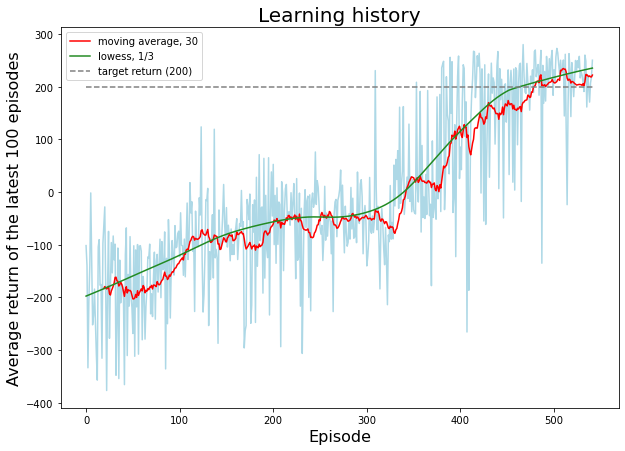

In [11]:
import pandas as pd
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

window_size = 20
moving_avgs = pd.Series(total_returns_history).rolling(window_size).mean()
lowess_values = lowess(total_returns_history, range(len(total_returns_history)), frac =  1/3)[:,1]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(range(len(total_returns_history)), total_returns_history, color = "lightblue")
ax.set_xlabel("Episode", fontsize = 16)
ax.set_ylabel("Average return of the latest 100 episodes", fontsize = 16)
ax.plot(range(len(total_returns_history)), moving_avgs, color = "red", label = "moving average, 30")
ax.plot(range(len(total_returns_history)), lowess_values, color = "forestgreen", label = "lowess, 1/3")
ax.hlines(200, 0, len(total_returns_history), linestyle = "dashed", color = "grey", label = "target return (200)")
ax.legend()
ax.set_title("Learning history", fontsize = 20)
plt.show()